In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.utils import to_categorical # one-hot-encoding

# build CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'



##  check the data

let's start with quick analysis of the data we are dealing with.

In [15]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv("../data/test_with_emotions.csv")

y_train = train_data['emotion']
X_train = train_data['pixels']

y_test = test_data['emotion']
X_test = test_data['pixels']


/tmp/ipykernel_16095/603603148.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


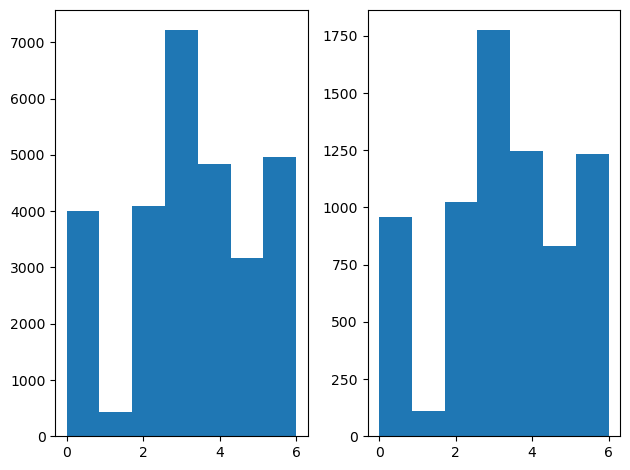

In [16]:
fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].hist(y_train, bins=7)
axs[1].hist(y_test, bins=7)

fig.show()

we can see that the emotion count is unbalanced:
- very few "1" emotion
- lots of "3" emotion
- other emotions are pretty balanced

Also, the train set (on the left) and the test set (on the right) are very similar

In [17]:
# check for missing values 
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# free some space
del train_data
del test_data

emotion    0
pixels     0
dtype: int64
emotion    0
pixels     0
dtype: int64


no missing values :)

## data preparation

In the code below, we'll do a few operation to reconstitute the image from the pixels :<br>

First, we normalize the values. The model will converge faster with values in range [0..1] instead of [0..255] <br>
Then, we reshape the image to get a 48x48x1 matrix. It means that we have a 48x48 pixels image with a single color canal, so the image will be in gray scale. For RGB images, 3 color canals are needed, we would have a 48x48x3 matrix

In [18]:
def reconstitute_images(X):
    # extract the pixels values and normalize them
    pixel_lists = X.str.split().apply(lambda x: [float(i)/255 for i in x])

    # Reshape the arrays into 48x48 matrices
    pixel_arrays = np.array(pixel_lists.tolist())
    images = pixel_arrays.reshape(-1, 48, 48, 1) 
    return images

X_train = reconstitute_images(X_train)
X_test = reconstitute_images(X_test)


let's see what these images look like !

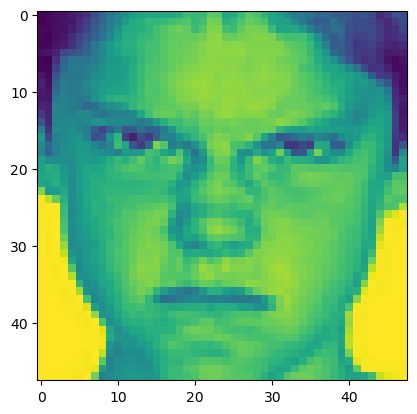

In [19]:
import random

image = X_train[random.randint(0,1000)]
plt.imshow(image[:,:,0])

One-Hot-Encoding 

In [20]:
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

print('test')

test


## Convolutional Neural Network

In [21]:
# the only difference between every conv layer is the amount of filter
# Therefore, let's create a function that only takes the filter as parameter
# and return the conv layer.
def Conv3x3(filter):
    return Conv2D(filters=filter, kernel_size=(3,3), padding="Same", activation="relu")

PoolLayer = MaxPool2D(pool_size=(2,2), strides=(2,2))

In [27]:
# VGG Neural Network

network = Sequential()

input_conv = Conv2D(filters=64, kernel_size=(3,3), padding="Same", activation="relu", input_shape=(48,48,1))
network.add(input_conv)
network.add(Conv3x3(64))
network.add(PoolLayer)
network.add(Dropout(0.25))

network.add(Conv3x3(128))
network.add(Conv3x3(128))
network.add(PoolLayer)
network.add(Dropout(0.25))


network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(PoolLayer)
network.add(Dropout(0.25))


network.add(Conv3x3(512))
network.add(Conv3x3(512))
network.add(Conv3x3(512))
network.add(PoolLayer)
network.add(Dropout(0.25))



# network.add(Conv3x3(512))
# network.add(Conv3x3(512))
# network.add(Conv3x3(512))
# network.add(PoolLayer)

# # Fully Connected Layers
network.add(Flatten())
network.add(Dense(4096, activation="relu"))
network.add(Dense(4096, activation="relu"))
network.add(Dropout(0.25))
network.add(Dense(7, activation="softmax"))

print(network.summary())


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_41 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  multiple                  0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 24, 24, 128)       73856     
                                                                 
 conv2d_43 (Conv2D)          (None, 24, 24, 128)       147584    
                                                      

In [14]:
# CNN Architecture (Digit Recognizer Modified)

network = Sequential()

ConvLayer32 = Conv2D(
    filters=32,
    kernel_size=(5,5),
    padding="Same",
    activation='relu'
)

ConvLayer64 = Conv2D(
    filters=64,
    kernel_size=(3,3),
    padding="Same",
    activation='relu',
)

PoolLayer1 = MaxPool2D(pool_size=(2,2))
PoolLayer2 = MaxPool2D(pool_size=(2,2), strides=(2,2))

# Convolution/Pooling
network.add(ConvLayer32)
network.add(ConvLayer32)
network.add(PoolLayer1)
network.add(Dropout(rate=0.25))

network.add(ConvLayer64)
network.add(ConvLayer64)
network.add(PoolLayer2)
network.add(Dropout(rate=0.25))

# Fully Connected
network.add(Flatten()) # convert the 2D matrix into a 1D vector
network.add(Dense(4096, activation="relu"))
network.add(Dense(4096, activation="relu"))
#network.add(Dropout(0.5))
network.add(Dense(7, activation="softmax"))

In [25]:
# The medium model

network = Sequential()

input_conv = Conv2D(filters=32, kernel_size=(3,3), padding="Same", activation="relu", input_shape=(48,48,1))

network.add(input_conv)
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.1))

network.add(Conv3x3(64))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.1))

network.add(Conv3x3(128))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.1))

network.add(Conv3x3(256))
network.add(MaxPool2D(pool_size=(2,2)))
network.add(Dropout(0.1))

network.add(Flatten())
network.add(Dense(units=128, activation='relu'))
network.add(Dropout(0.2))
network.add(Dense(7, activation='softmax'))

network.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 12, 12, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_11 (Dropout)        (None, 12, 12, 64)       

In [23]:
# The FC-less model

network = Sequential()

input_layer = Conv2D(64, (3,3), padding="same", activation='relu', input_shape=(48,48,1))

network.add(input_layer)
network.add(Conv3x3(64))
network.add(Dropout(0.3))

network.add(Conv3x3(128))
network.add(Conv3x3(128))
network.add(Conv3x3(128))
network.add(Dropout(0.3))

network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Dropout(0.3))

network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Conv3x3(256))
network.add(Dropout(0.3))

network.add(Conv3x3(512))
network.add(Conv3x3(512))
network.add(Conv3x3(512))
network.add(Conv3x3(512))
network.add(Dropout(0.3))

network.add(Flatten())
network.add(Dense(7, activation='softmax'))

network.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 conv2d_54 (Conv2D)          (None, 48, 48, 64)        36928     
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 conv2d_55 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_56 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 conv2d_57 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 dropout_1 (Dropout)         (None, 48, 48, 128)      

In [28]:
#optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08) # default params

network.compile(
    optimizer = 'adam' ,
    loss = "categorical_crossentropy",
    metrics=["accuracy"])

In [29]:
history_obj = network.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=64
)


Epoch 1/40
449/449 [==============================] - 723s 2s/step - loss: 1.8195 - accuracy: 0.2507 - val_loss: 1.8191 - val_accuracy: 0.2471
Epoch 2/40
449/449 [==============================] - 717s 2s/step - loss: 1.8126 - accuracy: 0.2513 - val_loss: 1.8159 - val_accuracy: 0.2471
Epoch 3/40
 19/449 [>.............................] - ETA: 11:05 - loss: 1.8253 - accuracy: 0.2294

KeyboardInterrupt: 

## Evaluation

accuracy inflection point :  1
loss inflection point : 31


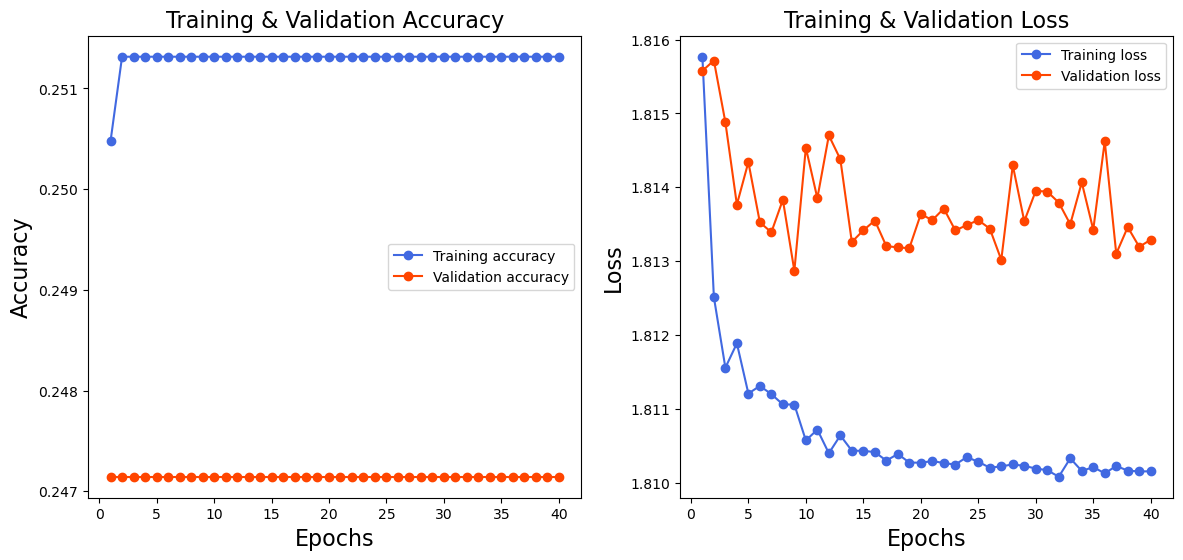

In [ ]:
history = history_obj.history

loss_values = history['loss']
val_loss_values = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
 
epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy,marker='o', color='royalblue', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, marker='o', color='orangered', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, marker='o', color='royalblue', label='Training loss')
ax[1].plot(epochs, val_loss_values, marker='o', color='orangered', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

best_epoch_acc = accuracy.index(np.max(accuracy))
best_epoch_loss = loss_values.index(np.min(loss_values))

print('accuracy inflection point : ', best_epoch_acc)
print('loss inflection point :', best_epoch_loss)

In [ ]:

pickle.dump(network, open("../results/neural_network.pkl", "wb"))

In [ ]:
proba_lists = network.predict(X_train)



898/898 [==============================] - 6s 7ms/step


In [ ]:
loss_and_acc = network.evaluate(X_test, y_test)
print(loss_and_acc)

225/225 [==============================] - 2s 7ms/step - loss: 1.3627 - accuracy: 0.6004
[1.3626726865768433, 0.6004458069801331]
